In [59]:
import numpy as np
import pandas as pd
import pickle
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import coint
import datetime

### Find Tickers
We would like to identify cointegrated pairs.
One way to find them is to look into some specific sectors.
For exp: 'utilities.csv' includes a list of active utilities.

In [76]:
filename='utilities.csv'
df = pd.read_csv(filename)
df.head()

,Ticker,Description,Price,Change %,Change,Technical Rating,Volume,Volume*Price,Market Capitalization,Price to Earnings Ratio (TTM),Basic EPS (TTM),Number of Employees,Sector
0,PCG,Pacific Gas & Electric Co.,13.83,-3.354298,-0.48,Buy,24222506,3.349973e+08,2.748945e+10,185.844156,0.1064,26000.0,Utilities
1,RUN,Sunrun Inc.,21.21,-7.621951,-1.75,Strong Sell,10480596,2.222934e+08,4.498730e+09,NaN,-0.5481,11383.0,Utilities
2,NEE,"NextEra Energy, Inc.",71.77,-1.805993,-1.32,Sell,8735692,6.269606e+08,1.425650e+11,55.960493,1.3138,15000.0,Utilities
3,EXC,Exelon Corporation,36.59,-1.719044,-0.64,Sell,6830065,2.499121e+08,3.628839e+10,13.743079,2.7108,31518.0,Utilities
4,FE,FirstEnergy Corp.,36.17,-2.559267,-0.95,Strong Sell,6503663,2.352375e+08,2.066737e+10,15.636716,2.3782,12395.0,Utilities


We want to trade with stocks with adequate demand from buyers and sellers, we can eliminate others by defining a cap for the trade volume.

In [84]:
 # Define a volume cap
volume_cap = 1000000

df = df[['Ticker','Description','Volume','Price']].sort_values(by='Volume', ascending=False)
high_volume = df.Volume>volume_cap
df_h = df[high_volume]
tickers = df_h.Ticker.tolist()
tickers

['PCG',
 'RUN',
 'NEE',
 'EXC',
 'FE',
 'PPL',
 'NI',
 'NOVA',
 'CNP',
 'SO',
 'DUK',
 'D',
 'AES',
 'AEP',
 'XEL',
 'ED',
 'EIX',
 'DTE',
 'CLNE',
 'VST',
 'LNT',
 'CMS',
 'ES',
 'PEG',
 'WEC',
 'SRE',
 'CEG',
 'NRG',
 'RNW',
 'AGR',
 'OGE',
 'AEE',
 'WTRG',
 'AWK',
 'UGI',
 'ETR',
 'AMPS']

In [88]:
 # Define a price interval if needed
price_low = 20 
price_high = 100

query="Price>"+str(price_low)+" & Price<"+str(price_high)
df_h_p = df_h.query(query)
tickers = df_h_p.Ticker.tolist()
tickers

['RUN',
 'NEE',
 'EXC',
 'FE',
 'PPL',
 'NI',
 'CNP',
 'SO',
 'DUK',
 'D',
 'AES',
 'AEP',
 'XEL',
 'ED',
 'EIX',
 'VST',
 'LNT',
 'CMS',
 'ES',
 'PEG',
 'WEC',
 'CEG',
 'NRG',
 'AGR',
 'OGE',
 'AEE',
 'WTRG',
 'UGI']

### Download Price Data
We will use yfinance (https://pypi.org/project/yfinance/) to downloed the closing princes of stocks.
More information is available on the next notebook which we will download and save a more detailed stock data.

In [89]:
# Enable to use start & end dates:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2022, 1, 1)

df = yf.download(tickers, start, end)["Close"]

# enable to use periods & intervals
# period = '3y'
# interval = '1d'
# df = yf.download(tickers, period=period, interval=interval)["Close"]

df.info()

[*********************100%***********************]  28 of 28 completed

1 Failed download:
- CEG: Data doesn't exist for startDate = 1514782800, endDate = 1641013200
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2018-01-02 00:00:00-05:00 to 2021-12-31 00:00:00-05:00
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AEE     1008 non-null   float64
 1   AEP     1008 non-null   float64
 2   AES     1008 non-null   float64
 3   AGR     1008 non-null   float64
 4   CEG     0 non-null      float64
 5   CMS     1008 non-null   float64
 6   CNP     1008 non-null   float64
 7   D       1008 non-null   float64
 8   DUK     1008 non-null   float64
 9   ED      1008 non-null   float64
 10  EIX     1008 non-null   float64
 11  ES      1008 non-null   float64
 12  EXC     1008 non-null   float64
 13  FE      1008 non-null   float64
 14  LNT     1008 non-null   float64
 15  NEE     1008 non-null   float64
 16  NI      

Check for null values and eliminate them:

In [90]:
df = df.dropna(axis=1)
new_tickers = df.columns.tolist()
print(f"we have {len(new_tickers)} tickers left")

we have 27 tickers left


### Find Cointegrated Pairs

We will perfom cointegration tests for all of the pairs that we can produce from the available tickers. We still need to perform more detailed tests for stationarity in the following notebooks.

In [91]:
# let's define a function to loop through the tickers and do a cointegration test for each combination
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue
            
            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))
                
    return stats, pvalues, pairs

See the result on a heatmap

[('AES', 'DUK'), ('AGR', 'CNP'), ('AGR', 'UGI'), ('CMS', 'D'), ('D', 'ES'), ('D', 'UGI'), ('D', 'WEC'), ('D', 'XEL'), ('ED', 'EIX'), ('ED', 'FE'), ('ED', 'OGE'), ('ED', 'PPL'), ('EIX', 'FE'), ('EIX', 'NI'), ('EIX', 'OGE'), ('EIX', 'PPL'), ('EIX', 'RUN'), ('EIX', 'VST'), ('ES', 'WEC'), ('FE', 'NI'), ('LNT', 'WTRG'), ('NI', 'OGE'), ('PPL', 'RUN'), ('PPL', 'VST'), ('SO', 'WTRG'), ('WEC', 'XEL')]


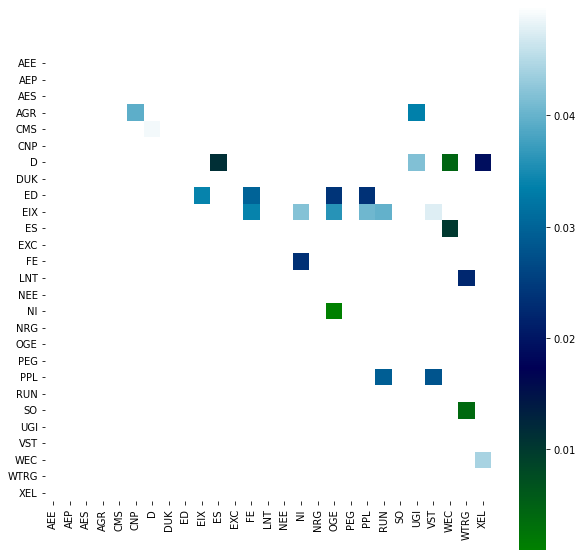

In [92]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs = cointegration_test(df,p_value)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    pvalues,
    xticklabels=new_tickers,
    yticklabels=new_tickers,
    cmap="ocean",
    mask=(pvalues >= 0.05),
    square=True
)
print(pairs)

### Filter For More Significant Pairs
Filter more to get more significant pairs, and eliminate empty cells.

,ES,OGE,WEC,WTRG,XEL
D,0.011,nan,0.005,nan,0.019
ES,nan,nan,0.010,nan,nan
NI,nan,0.001,nan,nan,nan
SO,nan,nan,nan,0.004,nan


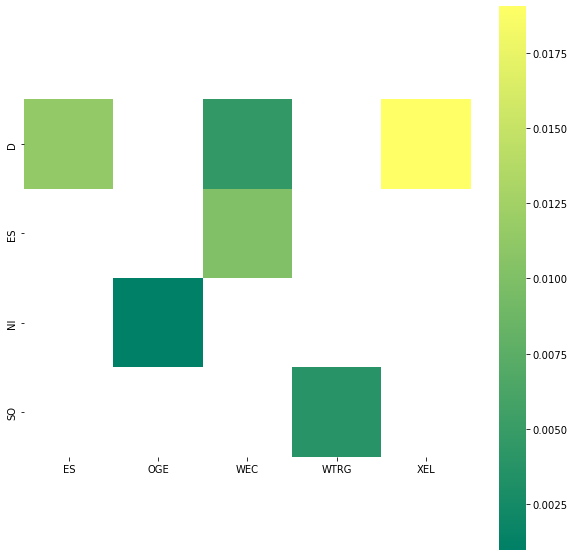

In [95]:
mask_matrix = (pvalues >= 0.02) # increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= new_tickers, columns = new_tickers)
scores_df = pd.DataFrame(scores, index= new_tickers, columns = new_tickers)
pvalues_df = pd.DataFrame(pvalues, index= new_tickers, columns = new_tickers)

df_f = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_f = df_f.dropna(how='all')

def gold_apply(x):
    color = {True: "background-color: #c78f2e", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color

# Another way to format table is applymap
# def color_map(x):
#     return f"color: {'red' if x > 0 else 'white'}"

# df_f.style.applymap(color_map)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_f,
    xticklabels=df_f.columns,
    yticklabels=df_f.index,
    cmap="summer",
    square=True
)
df_f.style.format(precision=3)\
.apply(gold_apply)

### Get List/Dic of Pairs

In [96]:
x_list = df_f.index.tolist()
y_list = df_f.columns.tolist()

new_pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_f.iloc[i,j]>0:
            new_pairs_list.append((x_list[i], y_list[j]))

new_pairs_list

[('D', 'ES'),
 ('D', 'WEC'),
 ('D', 'XEL'),
 ('ES', 'WEC'),
 ('NI', 'OGE'),
 ('SO', 'WTRG')]

In [97]:
new_pairs_str =[] # list of pairs as string A-B

for column in df_f:
    toprint = df_f.index[df_f[column]>0].tolist()
    new_pairs_str.append([column + "-" + s for s in toprint])
    
new_pairs_str

[['ES-D'], ['OGE-NI'], ['WEC-D', 'WEC-ES'], ['WTRG-SO'], ['XEL-D']]

In [98]:
new_pairs_dic= {} # list of pairs as dictionary {'A':['B','C']}

for column in df_f:
    new_pairs_dic[column] = df_f.index[df_f[column]>0].tolist()

new_pairs_dic

{'ES': ['D'], 'OGE': ['NI'], 'WEC': ['D', 'ES'], 'WTRG': ['SO'], 'XEL': ['D']}

### Save to file
Save dataframa as pickle to use for the next steps

In [99]:
df_f.to_pickle("pairs_to_download.pkl")